# Reproducing figure 17 of Billangeon et al.

This notebook computes the Hamiltonian of the tunable gap flux qubit capacitively coupled to a quantum harmonic oscillator circuit shown in figure 16 of Billangeon. 

<center><img src="../images/circuit - resonator coupling.png" width=600 height=600/></center>
<center>Figure 16: Qubit + Resonator Circuit</center>

It then goes on to compute the parameters of the approximated Hamiltonian

\begin{equation}
    H = \omega_r' a^\dagger a + \frac{\Delta}{2} \sigma_z + i g_{\parallel} \sigma_z \left( a^\dagger - a \right) + g_{\perp} \sigma_z \left( a^\dagger + a \right)
\end{equation}

with the aim of reproducing the behaviour seen in figure 17.

<center><img src="../images/fig_17.png" width=800 height=800/></center>
<center>Figure 17: Figures to reproduce</center>

## Install and Import Required Packages

In [1]:
%%capture out
%pip install matplotlib
%pip install scipy
%pip install matplotlib
%pip install tdqm
%pip install scienceplots

In [1]:
import os
import sys

os.environ["PATH"] += os.pathsep + '/Library/TeX/texbin'

if __name__ == '__main__':
    root_dir = 'Transmon-Project'
    root_path = os.path.abspath('').split(root_dir)[0] + root_dir
    sys.path.append(root_path)

import numpy as np
import scipy as sp
import matplotlib.gridspec as gridspec
import matplotlib.pyplot as plt
import scienceplots

from circuit_models.resonator_coupling_circuit import RCCircuit

from tqdm import tqdm

plt.style.use('science')

## Initialise Constants

In [2]:
h = 6.62607015e-34
hbar = 1.054571817e-34
e_charge = 1.60217663e-1

In [3]:
system = RCCircuit(ncut=5)

g_parr = system.calc_g_parr()
print(f"g parallel: {g_parr}")

g_perp = system.calc_g_perp()
print(f"g perpendicular: {g_perp}")

delta = system.calc_probe_freq()
print(f"delta: {delta}")

omega = system.calc_cavity_freq()
print(f"omega: {omega}")

g parallel: (4.372399893819888e-26-8.915677401358789e-40j)
g perpendicular: (-8.92486381699852e-40+4.993748924991481e-38j)
delta: 4.753975274530686e-25
omega: (3.2448324602517104e-24-5.165746658887006e-40j)



## Visualise Hamiltonians

In [ ]:
system = RCCircuit(ncut=2, mcut=2)

H_prt = system.get_H_prt()
H_p = system.get_H_p()

if type(H_p) == sp.sparse.csr.csr_matrix:
    H_p = H_p.toarray()
    H_prt = H_prt.toarray()

f = plt.figure(figsize=(15,7))

ax1 = f.add_subplot(121)
ax1.title.set_text('Hamiltonian Matrix of the Qubit Resonator System')
im1 = ax1.imshow(np.real(H_prt), cmap=plt.get_cmap('cool'))
f.colorbar(im1)

ax2 = f.add_subplot(122)
ax2.title.set_text('Hamiltonian of Qubit')
im2 = ax2.imshow(np.real(H_p), cmap=plt.get_cmap('cool'))
f.colorbar(im2)
plt.show()

In [ ]:
system = RCCircuit(ncut=1, mcut=2, ng=0.5, Ejp=121e8)

kin_p = system.kin_p()
pot_p = system.pot_p()

if type(kin_p) == sp.sparse.csr.csr_matrix:
    kin_p = kin_p.toarray()
    pot_p = pot_p.toarray()

f = plt.figure(figsize=(15,7))

ax1 = f.add_subplot(121)
ax1.title.set_text('Kinetic Matrix of the Qubit')
im1 = ax1.imshow(np.real(kin_p), cmap=plt.get_cmap('cool'))
f.colorbar(im1)

ax2 = f.add_subplot(122)
ax2.title.set_text('Potential Matrix of the Qubit')
im2 = ax2.imshow(np.real(pot_p), cmap=plt.get_cmap('cool'))
f.colorbar(im2)
plt.show()

## Qubit Spectrum

In [ ]:
evals_list = []
fluxes = np.linspace(0,1,10)

system = RCCircuit(ncut=6, Ccp=0, ng=0)
for flux in tqdm(fluxes):
    system.flux = flux
    evals, evecs = system.diagonalise_p(update=True)
    evals_list.append(np.diff(evals[:5]))

evals = np.asarray(evals_list)

In [ ]:
plt.figure(figsize=(8,6))
plt.plot(fluxes, (evals * 1e-9) / h)
plt.xlabel('Flux Bias')
plt.ylabel('Energy (GHz)')
plt.legend([f'E_{n+1} - E_{n}' for n in range(len(evals))])
plt.show()

### Qubit Simulation

#### Fig 17a

In [ ]:
fig_17a_ngs_p = np.linspace(-1, 1, 100)
# alphas = np.linspace(0.25, 0.6, 8)
alphas = [0.2, 0.4, 0.6]

system = RCCircuit(ncut=4, Ccp=0)

fig_17a_results_p = {}

for alpha in alphas:
    fig_17a_results_p[alpha] = []
    system.alphas = [alpha] * 4
    for ng in tqdm(fig_17a_ngs_p):
        system.ng = ng

        evals, evecs = system.diagonalise_p(update=True)
        evals = np.real(evals) * 1e-9 / h

        delta = evals[1] - evals[0]

        fig_17a_results_p[alpha].append(delta)

In [ ]:
plt.figure(figsize=(8,6))
plt.title('Qubit energy gap (calculated from eigenenergies)')
plt.xlabel('ng')
plt.ylabel('$\\Delta_p$ (GHz)')

for alpha in fig_17a_results_p.keys():
    plt.plot(fig_17a_ngs_p, fig_17a_results_p[alpha], label=round(alpha,2))
plt.legend(title='alpha')
plt.show()

In [ ]:
pparam = dict(xlabel='$n_g$', ylabel='$\Delta_p / h$ (GHz)')

with plt.style.context(['ieee', 'grid']):
    fig, ax = plt.subplots(figsize=(6,4))
    for alpha in fig_17a_results_p.keys():
        ax.plot(fig_17a_ngs_p, fig_17a_results_p[alpha], label=round(alpha,2))
    ax.legend(title='$\\alpha$')
    ax.set(**pparam)
    ax.xaxis.label.set_size(16)
    ax.yaxis.label.set_size(16)
    fig.savefig('../figures/Resonator Coupling/Delta wrt alpha ng.png', dpi=300)
    plt.show()

#### Compare to Billangeon

In [ ]:
plt.figure(figsize=(8,6))
plt.title('Qubit energy gap (calculated from eigenenergies)')
plt.xlabel('ng')
plt.ylabel('∆ (GHz)')

img = plt.imread("../images/fig_17a.png")
for alpha in fig_17a_results_p.keys():
    plt.plot(fig_17a_ngs_p, fig_17a_results_p[alpha], 'r')
plt.ylim([0,16])

ext = [-1, 1, 0.00, 16]
plt.imshow(img, extent=ext)

aspect=img.shape[0]/float(img.shape[1])*((ext[1]-ext[0])/(ext[3]-ext[2]))
plt.gca().set_aspect(aspect)

plt.show()

#### Fig 17b

In [ ]:
fig_17b_ngs_p = np.linspace(-1, 1, 10)
# fig_17b_Ccs_p = np.linspace(0, 10e-15, 12)
fig_17b_Ccps_p = [0e-15, 5e-15, 10e-15]

system = RCCircuit(ncut=5)

fig_17b_results_p = {}

for Ccp in fig_17b_Ccps_p:
    fig_17b_results_p[Ccp] = []
    system.Ccp = Ccp
    for ng in tqdm(fig_17b_ngs_p):
        system.ng = ng

        delta = system.calc_probe_freq(update=True) * 1e-9 / h

        fig_17b_results_p[Ccp].append(delta)

In [ ]:
plt.figure(figsize=(8,6))
plt.title('Qubit energy gap (calculated from eigenenergies)')
plt.xlabel('ng')
plt.ylabel('$\\Delta$ (GHz)')

for Ccp in fig_17b_results_p.keys():
    plt.plot(fig_17b_ngs_p, fig_17b_results_p[Ccp], label=Ccp)
plt.legend(title='$C_cp$')
plt.show()

In [ ]:
pparam = dict(xlabel='$n_g$', ylabel='$\Delta_p / h$ (GHz)')

with plt.style.context(['ieee', 'grid']):
    fig, ax = plt.subplots(figsize=(6,4))
    for Ccp in fig_17b_results_p.keys():
        ax.plot(fig_17b_ngs_p, fig_17b_results_p[Ccp], label=int(Ccp * 1e15))
    ax.legend(title='$C_{cp}$ (fF)')
    ax.set(**pparam)
    ax.xaxis.label.set_size(16)
    ax.yaxis.label.set_size(16)
    fig.savefig('../figures/Resonator Coupling/Delta wrt Ccp ng.png', dpi=300)
    plt.show()

In [ ]:
plt.figure(figsize=(8,6))
plt.title('Qubit energy gap (calculated from eigenenergies)')
plt.xlabel('ng')
plt.ylabel('∆ (GHz)')

img = plt.imread("../images/fig_17b.png")
for Cc in fig_17b_results_q.keys():
    plt.plot(fig_17b_ngs_q, fig_17b_results_q[Cc], 'r')

ext = [-1, 1, 0.00, 6]
plt.imshow(img, extent=ext)

aspect=img.shape[0]/float(img.shape[1])*((ext[1]-ext[0])/(ext[3]-ext[2]))
plt.gca().set_aspect(aspect)

plt.show()

#### Fig 17c

In [ ]:
fig_17c_ngs_p = np.linspace(-1, 1, 100)
# fig_17c_Ccps_p = [val * 1e-15 for val in range(1,9)]
fig_17c_Ccps_p = [1e-15, 4e-15, 8e-15]

system = RCCircuit(ncut=5)

fig_17c_g_parr_results = {}
fig_17c_g_perp_results = {}

for Ccp in fig_17c_Ccps_p:
    fig_17c_g_parr_results[Ccp] = []
    fig_17c_g_perp_results[Ccp] = []
    system.Ccp = Ccp
    for ng in tqdm(fig_17c_ngs_p):
        system.ng = ng

        system.init_prod_states(update=True)

        g_parr = system.calc_g_parr() * 1e-6 / h
        g_perp = system.calc_g_perp() * 1e-6 / h

        fig_17c_g_parr_results[Ccp].append(g_parr)
        fig_17c_g_perp_results[Ccp].append(g_perp)

In [ ]:
pparam = dict(xlabel='$n_g$', ylabel='$|g_\parallel| / h$ (MHz)')

with plt.style.context(['ieee', 'grid']):
    fig, ax = plt.subplots(figsize=(6,4))
    for Ccp in fig_17c_g_parr_results.keys():
        ax.plot(fig_17c_ngs_p, np.abs(fig_17c_g_parr_results[Ccp]), label=round(Ccp * 1e15))
    ax.legend(title='$C_{cp}$ (fF)')
    ax.set(**pparam)
    ax.xaxis.label.set_size(16)
    ax.yaxis.label.set_size(16)
    fig.savefig('../figures/Resonator Coupling/g_parr_wrt_ng_qubit.png', dpi=300)
    plt.show()

In [ ]:
pparam = dict(xlabel='$n_g$', ylabel='$g_\perp / h$ (Hz)')

with plt.style.context(['science', 'grid']):
    fig, ax = plt.subplots(figsize=(6,4))
    for Cc in fig_17c_g_perp_results.keys():
        ax.plot(fig_17c_ngs_q, [val * 1e6 for val in fig_17c_g_perp_results[Cc]], label=Cc)
    ax.legend(title='$C_c$ (fF)')
    ax.set(**pparam)
    fig.savefig('../figures/Resonator Coupling/g_perp_wrt_ng_qubit.png', dpi=300)
    plt.show()

In [ ]:
plt.figure(figsize=(8,6))
plt.title('Qubit energy gap (calculated from eigenenergies)')
plt.xlabel('ng')
plt.ylabel('g_|| (MHz)')

img = plt.imread("../images/fig_17c.png")
for alpha in fig_17c_results_q.keys():
    plt.plot(fig_17c_ngs_q, fig_17c_results_q[alpha], 'k', alpha=[0.7] * 4)
plt.ylim([0,275])

ext = [-1, 1, 0.00, 275]
plt.imshow(img, extent=ext)

aspect=img.shape[0]/float(img.shape[1])*((ext[1]-ext[0])/(ext[3]-ext[2]))
plt.gca().set_aspect(aspect)

plt.show()

#### Fig 17c Alpha Dispersion

In [14]:
import pickle

fig_17c_ngs_p = np.linspace(-0.5, -0.45, 1000)
alpha2s = [0.41]

system = RCCircuit(ncut=7)

alpha_disp_results = {}

for alpha2 in alpha2s:
    if alpha2 in alpha_disp_results.keys():
        continue

    alpha_disp_results[alpha2] = {
        'ng': [],
        'g_parr': [],
        'g_perp': [],
        'probe_freq': [],
        'cavity_freq': [],
        'target_freq': []
    }

    system.alphas = [0.4, alpha2, 1, 1]
    for ng in tqdm(fig_17c_ngs_p):
        system.ng = ng

        g_parr = system.calc_g_parr(update=True) * 1e-6 / h
        g_perp = system.calc_g_perp() * 1e-6 / h
        probe_freq = system.calc_probe_freq() * 1e-9 / h
        cavity_freq = system.calc_cavity_freq() * 1e-9 / h
        target_freq = system.calc_target_freq() * 1e-9 / h

        alpha_disp_results[alpha2]['ng'].append(ng)
        alpha_disp_results[alpha2]['g_parr'].append(g_parr)
        alpha_disp_results[alpha2]['g_perp'].append(g_perp)
        alpha_disp_results[alpha2]['probe_freq'].append(probe_freq)
        alpha_disp_results[alpha2]['cavity_freq'].append(cavity_freq)
        alpha_disp_results[alpha2]['target_freq'].append(target_freq)
    
    with open('../figures/Resonator Coupling/alpha_disp_results_zoom.pkl', 'wb') as f:
        pickle.dump(alpha_disp_results, f)


100%|██████████| 1000/1000 [43:15<00:00,  2.60s/it]


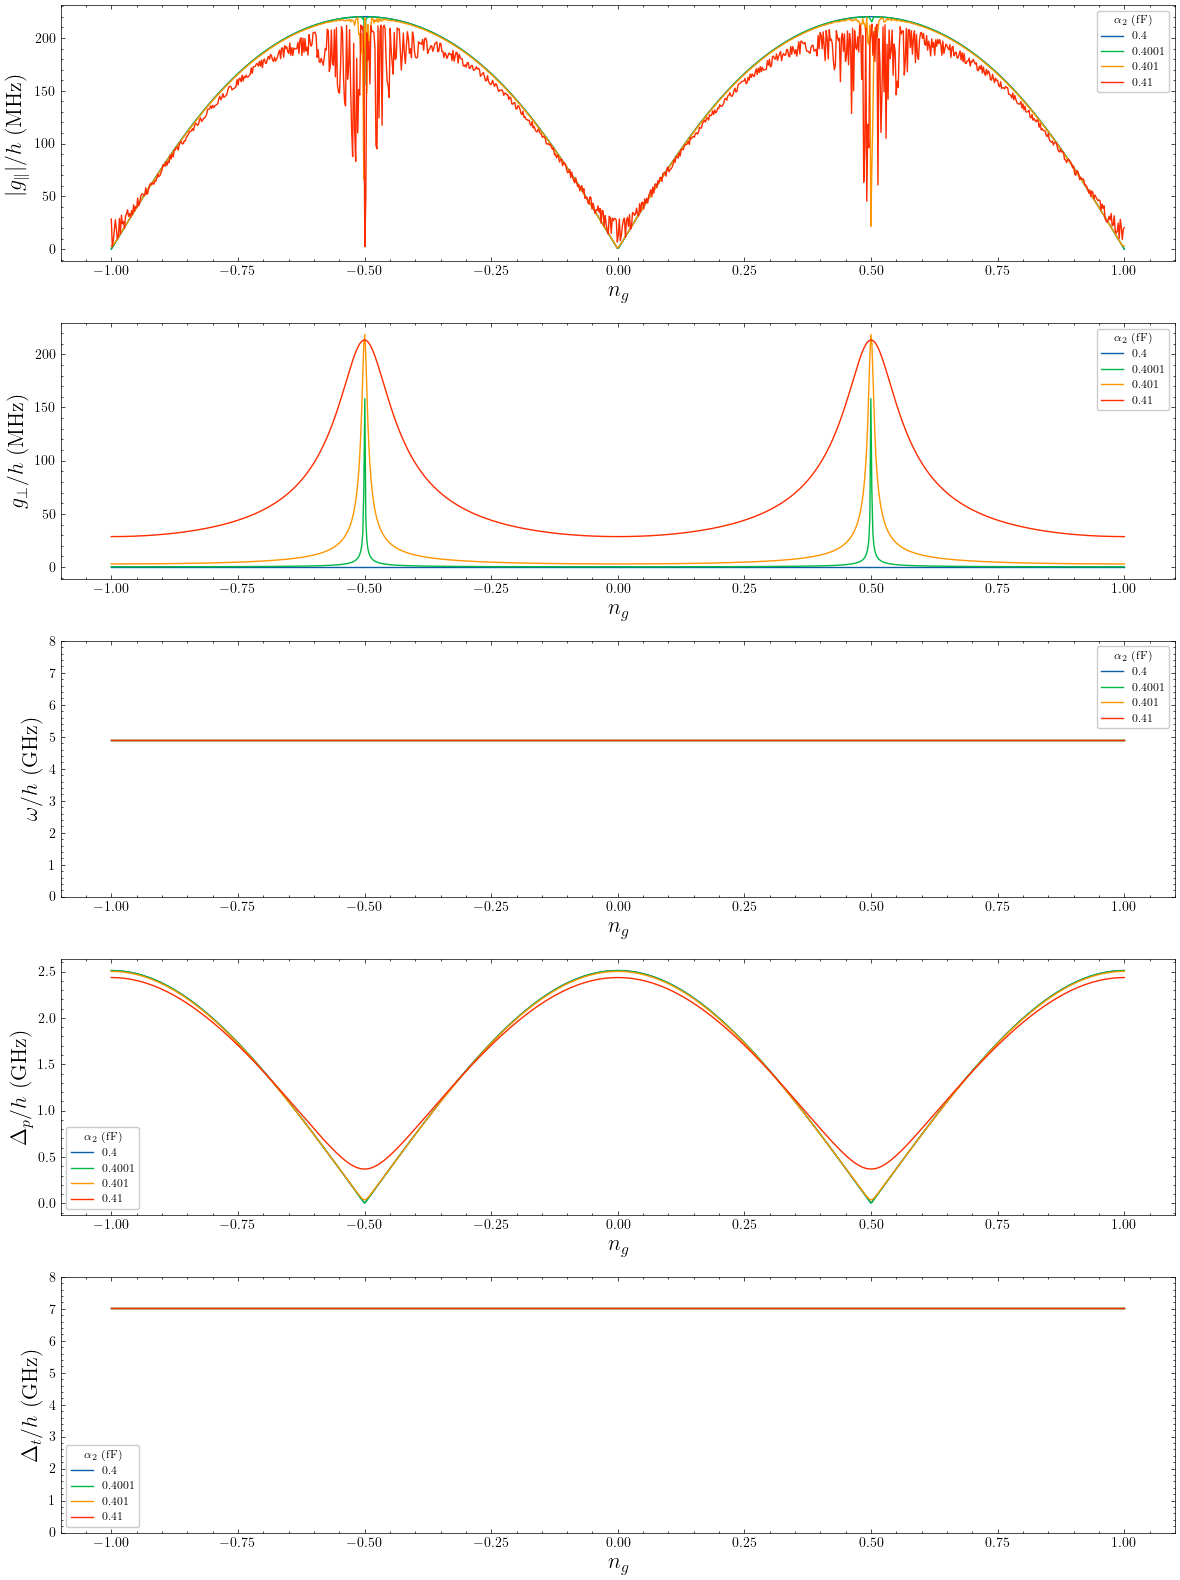

In [9]:
with open('../figures/Resonator Coupling/alpha_disp_results.pkl', 'rb') as f:
    alpha_disp_results = pickle.load(f)

obserables = [
    {'name': 'g_parr', 'ylabel': '$|g_\parallel| / h$ (MHz)'},
    {'name': 'g_perp', 'ylabel': '$g_\perp / h$ (MHz)'},
    {'name': 'cavity_freq', 'ylabel': '$\omega / h$ (GHz)', 'y_lim': [0, 8]},
    {'name': 'probe_freq', 'ylabel': '$\Delta_p / h$ (GHz)'},
    {'name': 'target_freq', 'ylabel': '$\Delta_t / h$ (GHz)', 'y_lim': [0, 8]}
]

fig, ax = plt.subplots(figsize=(12, 16), nrows=5, ncols=1)
ax = ax.flatten()
for idx, obs in enumerate(obserables):
    pparam = dict(xlabel='$n_g$', ylabel=obs['ylabel'])

    with plt.style.context(['ieee', 'grid']):
        for alpha in alpha_disp_results.keys():
            ax[idx].plot(alpha_disp_results[alpha]['ng'], np.abs(alpha_disp_results[alpha][obs['name']]), label=alpha)
        
        if 'y_lim' in obs.keys():
            ax[idx].set_ylim(obs['y_lim'])
        
        ax[idx].legend(title='$\\alpha_2$ (fF)')
        ax[idx].set(**pparam)
        ax[idx].xaxis.label.set_size(16)
        ax[idx].yaxis.label.set_size(16)

plt.tight_layout()
fig.savefig(f'../figures/Resonator Coupling/alpha_disp_results.png', dpi=300)
plt.show()

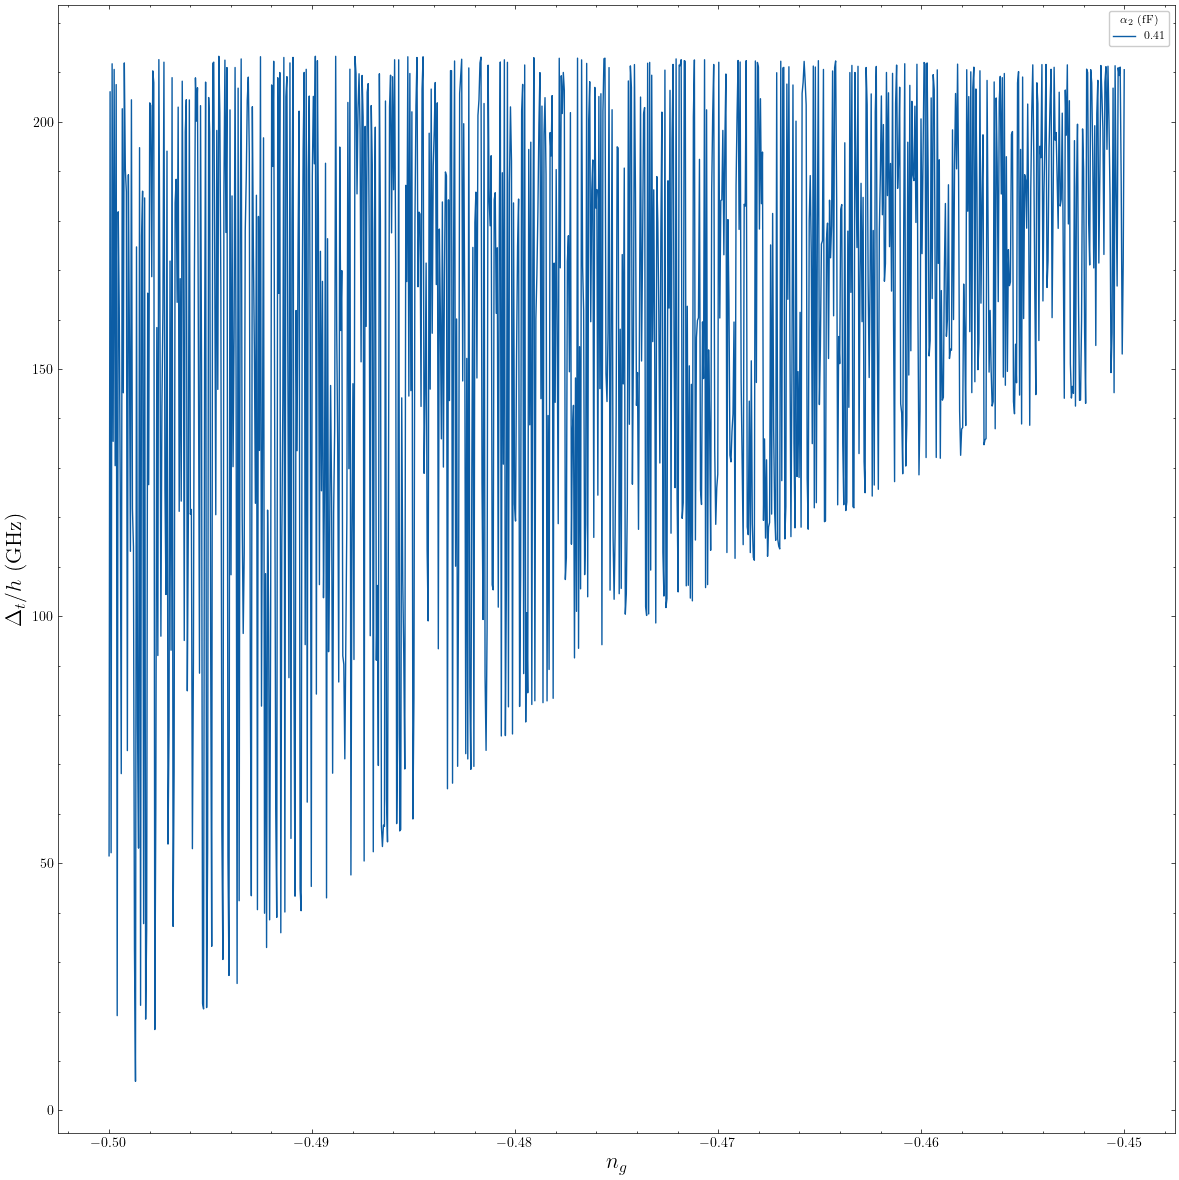

In [15]:
with open('../figures/Resonator Coupling/alpha_disp_results_zoom.pkl', 'rb') as f:
    alpha_disp_results = pickle.load(f)

fig, ax = plt.subplots(figsize=(12, 12))   
pparam = dict(xlabel='$n_g$', ylabel=obs['ylabel'])

with plt.style.context(['ieee', 'grid']):
    for alpha in alpha_disp_results.keys():
        ax.plot(alpha_disp_results[alpha]['ng'], np.abs(alpha_disp_results[alpha]['g_parr']), label=alpha)
    
    ax.legend(title='$\\alpha_2$ (fF)')
    ax.set(**pparam)
    ax.xaxis.label.set_size(16)
    ax.yaxis.label.set_size(16)

plt.tight_layout()
fig.savefig(f'../figures/Resonator Coupling/alpha_disp_results_g_parr_zoom.png', dpi=300)
plt.show()

#### Fig 17d

In [ ]:
fig_17d_Ccps_p = np.linspace(0, 10e-15, 100)

fig_17d_results_p = []

system = RCCircuit(ncut=5, ng=0.25, Ccp=Ccp, mcut=10)
for Ccp in tqdm(fig_17d_Ccps_p):
    system.Ccp = Ccp

    g_parr = system.calc_g_parr(update=True) * 1e-6 / h

    fig_17d_results_p.append(g_parr)

In [ ]:
plt.figure(figsize=(8,6))
plt.title('Longitudinal Coupling (calculated from eigenenergies)')
plt.xlabel('$C_{cp}$ (fF)')
plt.ylabel('$g_\parallel$ (MHz)')

plt.plot([val * 1e15 for val in fig_17d_Ccps_p], fig_17d_results_p)
plt.show()

In [ ]:
pparam = dict(xlabel='$C_{cp}$ (fF)', ylabel='$|g_\\parallel| / h$ (MHz)')

with plt.style.context(['ieee', 'grid']):
    fig, ax = plt.subplots(figsize=(6,4))
    ax.plot([val * 1e15 for val in fig_17d_Ccps_p], fig_17d_results_p)
    ax.set(**pparam)
    ax.xaxis.label.set_size(16)
    ax.yaxis.label.set_size(16)
    fig.savefig('../figures/Resonator Coupling/g_parr wrt Ccp.png', dpi=300)
    plt.show()

In [ ]:
plt.figure(figsize=(8,6))
plt.xlabel('$C_{cp}$ (fF)')
plt.ylabel('$g_\parallel$ (MHz)')

img = plt.imread("../images/fig_17d.png")
plt.plot([val * 1e15 for val in fig_17d_Ccps_p], fig_17d_results_p, 'r')
plt.ylim([0,200])

ext = [0, 10, 0.00, 200]
plt.imshow(img, extent=ext)

aspect=img.shape[0]/float(img.shape[1])*((ext[1]-ext[0])/(ext[3]-ext[2]))
plt.gca().set_aspect(aspect)

plt.show()

# Determine Approximate Hamiltonian Parameters

We assume that the Hamiltonian can be approximated by

\begin{equation}
    H = \omega_r' a^\dagger a + \frac{\Delta}{2} \sigma_z + i g_{\parallel} \sigma_z \left( a^\dagger - a \right) + g_{\perp} \sigma_x \left( a^\dagger + a \right)
\end{equation}

which when writing the two subspaces explicitly is written as

\begin{equation}
    H = \omega_r' \mathbb{1} \otimes a^\dagger a + \frac{\Delta}{2} \sigma_z \otimes \mathbb{1} + i g_{\parallel} \sigma_z \otimes \left( a^\dagger - a \right) + g_{\perp} \sigma_x \otimes \left( a^\dagger + a \right)
\end{equation}

To find the parameters I previously took the following overlaps:

\begin{equation}
    \langle 0 | \langle 0 | H | 0 \rangle | 0 \rangle = \frac{\Delta}{2}
\end{equation}

\begin{equation}
    \langle 0 | \langle 1 | H | 0 \rangle | 1 \rangle = \omega_r' + \frac{\Delta}{2}
\end{equation}

\begin{equation}
    \langle + | \langle 1 | H | - \rangle | 0 \rangle = i g_{\parallel}
\end{equation}

\begin{equation}
    \langle 1 | \langle 1 | H | 0 \rangle | 0 \rangle = g_{\perp}
\end{equation}

where we use the notation $| \text{Qubit} \rangle | \text{Cavity} \rangle$

This did not yield the expected results for $ \Delta $ (but did yield correct* results for $\omega$ and the couplings), instead for $\Delta$ taking:

\begin{equation}
    \langle 1 | \langle 0 | H | 1 \rangle | 0 \rangle - \langle 0 | \langle 0 | H | 0 \rangle | 0 \rangle = \frac{\Delta}{2}
\end{equation}

has yielded the Qubit + Resontar graphs of fig17(a,b)

*correct up to a factor of ~1.8x

### Evaluate parameters

In [ ]:
system = RCCircuit(ncut=2, mcut=2, ng=0)
H_q = system._plot_qubit_states()

In [ ]:
system = RCCircuit(ncut=5, ng=0.5)

g_parr = system.calc_g_parr()
print(f"g parallel: {g_parr}")

g_perp = system.calc_g_perp()
print(f"g perpendicular: {g_perp}")

delta = system.calc_probe_freq()
print(f"delta: {delta}")

omega = system.calc_cavity_freq()
print(f"omega: {omega}")

### Expected $\omega_r'$

Here we compute the expected resonant frequency of the resonator using the equation

\begin{equation}
    \omega_r' = \hbar / \sqrt{L_r C_r'}
\end{equation}

where $C_r'$ is the renormalised resonator capacitance, as defined in eq A16.

In [ ]:
omega_exp = system.calc_bil_omega()
print(f"omega exp: {omega_exp}")

## Calculating Coupling with Eq A15 

In Billangeon et al they express the coupling parameters as:

\begin{equation}
    g_\perp = \langle 1 | \sqrt{\frac{\hbar}{2 Z_r'}} \left[ \alpha (1 + \alpha) \frac{C_c}{C_0^2} (\hat{q}_1 + \hat{q}_2) + (1 + \alpha)^2 \frac{C_c}{C_0^2} \hat{q}_I \right] | 0 \rangle
\end{equation}

\begin{equation}
    g_\parallel = \langle + | \sqrt{\frac{\hbar}{2 Z_r'}} \left[ \alpha (1 + \alpha) \frac{C_c}{C_0^2} (\hat{q}_1 + \hat{q}_2) + (1 + \alpha)^2 \frac{C_c}{C_0^2} \hat{q}_I \right] | - \rangle
\end{equation}

In [ ]:
g_parr_bil, g_perp_bil = system.calc_bil_coupling()

print(f"g parallel: {g_parr_bil}")
print(f"g perpendicular: {g_perp_bil}")

## Figure 17a

In [ ]:
system = RCCircuit(ncut=6, Cc=0)
fig17a_ngs_qr = np.linspace(-1, 1, 100)
alphas = np.linspace(0.25, 0.6, 8)
fig17a_data_qr = {}

for alpha in alphas:
    system.alpha = alpha
    fig17a_data_qr[alpha] = []
    for ng in tqdm(fig17a_ngs_qr):
        system.ng = ng

        # Full Hamiltonina Approach
        delta = system.calc_probe_freq(update=True)
        fig17a_data_qr[alpha].append(delta)

In [ ]:
plt.figure(figsize=(8,6))
plt.title('Figure 17a: Full Hamiltonian Approach')
plt.xlabel('ng')
plt.ylabel('∆ / h (GHz)')
for alpha in fig17a_data_qr.keys():
    plt.plot(fig17a_ngs_qr, [np.real(delta * 1e-9) / h for delta in fig17a_data_qr[alpha]], label=round(alpha,2))
plt.legend(title='alpha')
plt.show()

In [ ]:
plt.figure(figsize=(8,6))
plt.title('Figure 17a: Full Hamiltonian Approach')
plt.xlabel('ng')
plt.ylabel('∆ / h (GHz)')

img = plt.imread("../images/fig_17a.png")
for alpha in fig17a_data_qr.keys():
    plt.plot(fig17a_ngs_qr, [np.real(delta * 1e-9) / h for delta in fig17a_data_qr[alpha]], 'r')

ext = [-1, 1, 0.00, 16]
plt.imshow(img, extent=ext)

aspect=img.shape[0]/float(img.shape[1])*((ext[1]-ext[0])/(ext[3]-ext[2]))
plt.gca().set_aspect(aspect)

plt.show()

## Figure 17b

In [ ]:
system = RCCircuit(ncut=6)
fig17b_ngs_qr = np.linspace(-1, 1, 50)
Ccs = np.linspace(0, 10e-15, 2)
fig17b_data_qr = {}

for Cc in Ccs:
    system.Cc = Cc
    fig17b_data_qr[Cc] = []
    for ng in tqdm(fig17b_ngs_qr):
        system.ng = ng

        # Full Hamiltonina Approach
        delta = system.calc_probe_freq(update=True)
        fig17b_data_qr[Cc].append(delta)

In [ ]:
plt.figure(figsize=(8,6))
plt.title('Figure 17b: Full Hamiltonian Approach')
plt.xlabel('$n_g$')
plt.ylabel('$\Delta$ / h (GHz)')
for Cc in fig17b_data_qr.keys():
    plt.plot(fig17b_ngs_qr, [np.real(delta * 1e-9) / h for delta in fig17b_data_qr[Cc]], label=Cc)
plt.legend(title='Cc')
plt.show()

In [ ]:
plt.figure(figsize=(8,6))
plt.title('Figure 17b: Full Hamiltonian Approach')
plt.xlabel('ng')
plt.ylabel('$\Delta$ / h (GHz)')

img = plt.imread("../images/fig_17b.png")
for alpha in fig17b_data_qr.keys():
    plt.plot(fig17b_ngs_qr, [np.real(delta * 1e-9) / h for delta in fig17b_data_qr[alpha]], 'r')

ext = [-1, 1, 0.00, 6]
plt.imshow(img, extent=ext)

aspect=img.shape[0]/float(img.shape[1])*((ext[1]-ext[0])/(ext[3]-ext[2]))
plt.gca().set_aspect(aspect)

plt.show()

## Figure 17c

In [ ]:
system = RCCircuit(ncut=5)
fig17c_ngs_qr = np.linspace(-1, 1, 100)
fig_17c_Ccs_qr = np.linspace(1e-15, 8e-15, 5)
fig17c_data_qr = {}

for Cc in fig_17c_Ccs_qr:
    system.Cc = Cc
    fig17c_data_qr[Cc] = []
    for ng in tqdm(fig17c_ngs_qr):
        system.ng = ng

        # Full Hamiltonina Approach
        g_parr = system.calc_g_parr(update=True)
        fig17c_data_qr[Cc].append(g_parr)

In [ ]:
plt.figure(figsize=(8,6))
plt.title('Figure 17c: Full Hamiltonian Approach')
plt.xlabel('ng')
plt.ylabel('g_|| / h (MHz)')
for Cc in fig17c_data_qr.keys():
    plt.plot(fig17c_ngs_qr, [np.abs(g_parr * 1e-6) / h for g_parr in fig17c_data_qr[Cc]], label=Cc)
plt.legend(title='Cc')
plt.show()

In [ ]:
plt.figure(figsize=(8,6))
plt.title('Figure 17c: Full Hamiltonian Approach')
plt.xlabel('ng')
plt.ylabel('g_|| / h (MHz)')

img = plt.imread("../images/fig_17c.png")
for Cc in fig17c_data_qr.keys():
    plt.plot(fig17c_ngs_qr, [np.abs(delta * 1e-6) / h for delta in fig17c_data_qr[Cc]], 'r')
plt.ylim([0,275])

ext = [-1, 1, 0.00, 275]
plt.imshow(img, extent=ext)

aspect=img.shape[0]/float(img.shape[1])*((ext[1]-ext[0])/(ext[3]-ext[2]))
plt.gca().set_aspect(aspect)

plt.show()

## Varying Cc (Figure 17d)

In [ ]:
system = RCCircuit(ncut=7)

fig_17d_Ccs_qr = np.linspace(0, 10e-15, 20)
fig17d_data_qr = {}
fig17d_data_qr['FH'] = []
fig17d_data_qr['Bil'] = []

for Cc in tqdm(fig_17d_Ccs_qr):
    system.Cc = Cc
    
    # Full Hamiltonina Approach
    g_parr = system.calc_g_parr(update=True)
    fig17d_data_qr['FH'].append(g_parr)

    # Billangeon Eq A15 Approach
    g_parr_bil, g_perp_bil = system.calc_bil_coupling(update=True)
    fig17d_data_qr['Bil'].append(g_parr_bil)

In [ ]:
plt.figure(figsize=(8,6))

plt.title('Figure 17d: Full Hamiltonnian Result')
plt.xlabel('Cc')
plt.ylabel('$g_\parallel$ / h (MHz)')
plt.plot(fig_17d_Ccs_qr, [np.abs(g_parr * 1e-6) / h for g_parr in fig17d_data_qr['FH']])
plt.show()

In [ ]:
plt.figure(figsize=(8,6))
plt.title('Figure 17d: Full Hamiltonian Approach')
plt.xlabel('$C_c$ (fF)')
plt.ylabel('$g_\parallel$ / h (MHz)')

img = plt.imread("../images/fig_17d.png")
plt.plot([val * 1e15 for val in fig_17d_Ccs_qr], [np.abs(g_parr * 1e-6) / h for g_parr in fig17d_data_qr['FH']], 'r')
plt.plot([val * 1e15 for val in fig_17d_Ccs_qr], [np.abs(g_parr * 1e-6) / h for g_parr in fig17d_data_qr['Bil']], 'r')
plt.ylim([0, 200])
    
ext = [0, 10, 0.00, 200]
plt.imshow(img, extent=ext)

aspect=img.shape[0]/float(img.shape[1])*((ext[1]-ext[0])/(ext[3]-ext[2]))
plt.gca().set_aspect(aspect)

plt.show()

## Charge cutoff vs simulation accuracy

In [ ]:
ncuts = range(2,9)

system = RCCircuit()

fig_17d_Ccs_qr = np.linspace(0, 10e-15, 20)
fig17d_data_qr = {}

for ncut in ncuts:
    system.ncut = ncut
    fig17d_data_qr[ncut] = []
    for Cc in tqdm(fig_17d_Ccs_qr):
        system.Cc = Cc

        # Full Hamiltonina Approach
        g_parr = system.calc_g_parr(update=True)
        fig17d_data_qr[ncut].append(g_parr)

In [ ]:
pparam = dict(xlabel='$C_c$ (fF)', ylabel='$g_\parallel / h$ (Hz)')

with plt.style.context(['science', 'grid']):
    fig, ax = plt.subplots(figsize=(6,4))
    for ncut in ncuts:
        ax.plot([val * 1e15 for val in fig_17d_Ccs_qr], [np.abs(g_parr * 1e-6) / h for g_parr in fig17d_data_qr[ncut]], label=ncut)
    ax.legend(title='$n_{ch}$')
    ax.set(**pparam)
    fig.savefig('../figures/Resonator Coupling/g_parr_wrt_Cc_convergence.png', dpi=300)
    plt.show()